#### Set up connection to database

In [270]:
import psycopg2
import pandas as pd

host = 'mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com'
port = "5432"
user = 'lhl_student'
pwd = 'lhl_student'
database = 'mid_term_project'

conn = psycopg2.connect(user = user,
                              password = pwd,
                              host = host,
                              port = port,
                              database = database)
def query(query, conn=conn):
    return pd.read_sql(query, conn)

###### 

###### 

# Task 4

### How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

##### Query necessary data from flights

In [250]:
df_flights = query('select fl_date, origin_airport_id, dest_airport_id, dep_time, arr_time, taxi_out, taxi_in from flights')

In [251]:
df_flights.to_csv('task04_flights_query.csv', index=False)

##### 

##### Extract the hour of arrival and departure

In [252]:
df_flights['fl_date'] = pd.to_datetime(df_flights['fl_date'])

In [253]:
def extractHours(time):
    if len(str(time)) == 6:
        return str(time)[0:2]
    elif len(str(time)) == 5:
        return str(time)[0:1]
    else:
        return 'Unavailable'

In [254]:
df_flights['dep_hour'] = df_flights['dep_time'].apply(extractHours)

In [255]:
df_flights['arr_hour'] = df_flights['arr_time'].apply(extractHours)

##### 

##### Split dataframe into arrivals vs departures

In [256]:
df_flights_dep = df_flights[['fl_date','origin_airport_id','dep_hour','taxi_out']]
df_flights_arr = df_flights[['fl_date','dest_airport_id','arr_hour','taxi_in']]

##### 

##### Create bins for each four hour increment

In [257]:
def defineBinHours(hour):
    if hour in ('1','2','3','4'):
        return 'Hours: 01-04'
    elif hour in ('5','6','7','8'):
        return 'Hours: 05-08'
    elif hour in ('9','10','11','12'):
        return 'Hours: 09-12'
    elif hour in ('13','14','15','16'):
        return 'Hours: 13-16'
    elif hour in ('17','18','19','20'):
        return 'Hours: 17-20'
    elif hour in ('21','22','23','24'):
        return 'Hours: 21-24'
    else:
        return 'Unavailable'

In [258]:
df_flights_dep['bin_hours'] = df_flights_dep['dep_hour'].apply(defineBinHours)

<ipython-input-258-caaf6c981bc8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flights_dep['bin_hours'] = df_flights_dep['dep_hour'].apply(defineBinHours)


In [259]:
df_flights_arr['bin_hours'] = df_flights_arr['arr_hour'].apply(defineBinHours)

<ipython-input-259-34e7dd067f13>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flights_arr['bin_hours'] = df_flights_arr['arr_hour'].apply(defineBinHours)


##### 

##### Create summary tables for arrivals and departures

In [260]:
df_summary_arr = df_flights_arr.groupby('bin_hours').agg(flight_count = ('fl_date', 'count'),
                                     taxi_mean = ('taxi_in', 'mean')).sort_values('bin_hours').reset_index()

In [261]:
df_summary_dep = df_flights_dep.groupby('bin_hours').agg(flight_count = ('fl_date', 'count'),
                                     taxi_mean = ('taxi_out', 'mean')).sort_values('bin_hours').reset_index()

##### 

##### Plot the taxi times and the traffic count for arrivals and departures

In [262]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

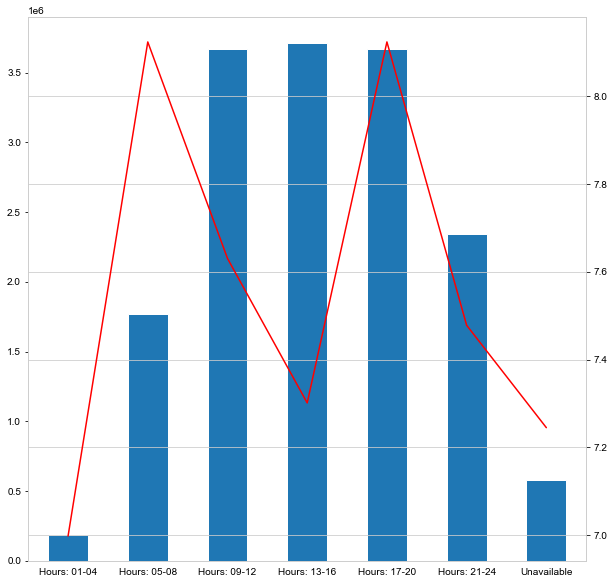

In [263]:
plt.figure(figsize=(10,10))
df_summary_arr['flight_count'].plot(kind='bar')
df_summary_arr['taxi_mean'].plot(secondary_y=True, color='r')
ax = plt.gca()
ax.set_xticklabels(df_summary_arr['bin_hours'])
plt.show()

### For arrivals, the average taxi time does ___not___ seem to be correlated to the traffic

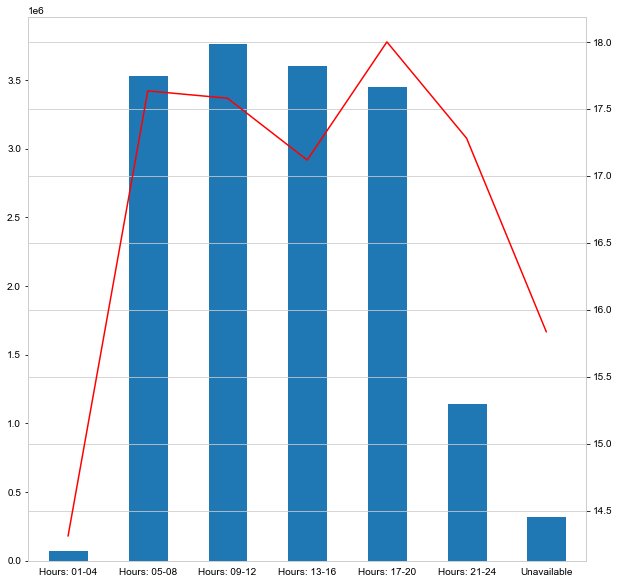

In [264]:
plt.figure(figsize=(10,10))
df_summary_dep['flight_count'].plot(kind='bar')
df_summary_dep['taxi_mean'].plot(secondary_y=True, color='r')
ax = plt.gca()
ax.set_xticklabels(df_summary_dep['bin_hours'], rotation=90)
plt.show()

### For departures, the average taxi time ___does___ seem to be correlated to the traffic

#### Explanation: For departures, when there is high traffic, there is a bottleneck where access to available runways is limited. For arrivals, such a bottleneck does not exist as the taxi time is computed from when the plane touches down to the the arrival at the gate. 

# 

***

# Task 5

### What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

In [271]:
df_delays = query('select fl_date, mkt_carrier_fl_num, dep_delay, arr_delay from flights')

In [272]:
df_delays.to_csv('task05_delays_query.csv', index=False)

In [277]:
outlier_index = df_delays[(df_delays['arr_delay'] < 500) & (df_delays['dep_delay'] > 1500)].index

In [278]:
df_delays.drop(df_delays.index[outlier_index], inplace=True)

##### 

#### Visualize the relationship between Arrival Delays and Departure Delays

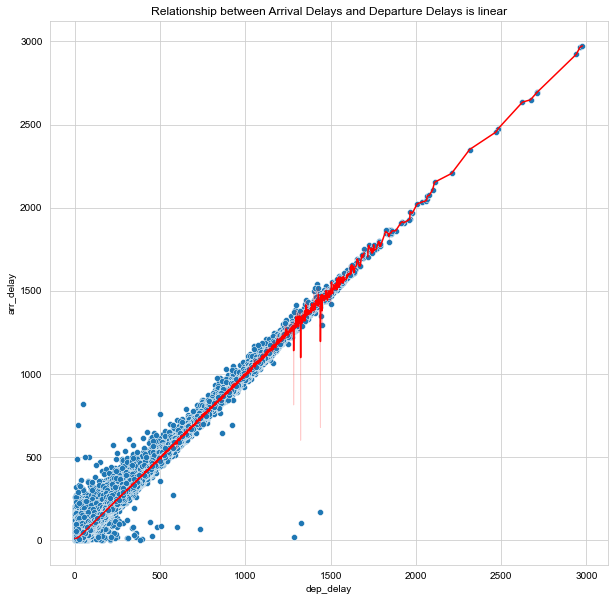

In [279]:
x = df_delays[df_delays['dep_delay'] > 0]['dep_delay']
y = df_delays[df_delays['arr_delay'] > 0]['arr_delay']

plt.figure(figsize=(10,10))
sns.scatterplot(x=x, y=y)
sns.lineplot(x=x, y=y, color='r')
plt.title('Relationship between Arrival Delays and Departure Delays is linear')
plt.show()

#### The scatterplot exhibits a strong linear relationship

#### 

In [280]:
import scipy.stats as stats

In [281]:
df_delays_corr = df_delays.dropna()

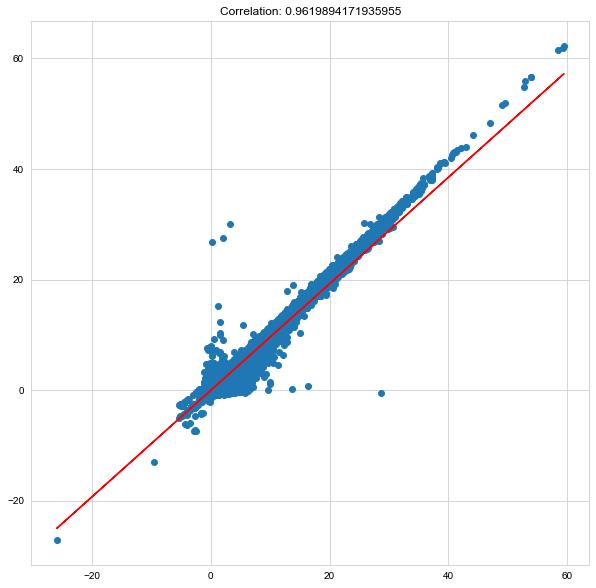

In [282]:
z_arr_delay = stats.zscore(df_delays_corr['arr_delay'])
z_dep_delay = stats.zscore(df_delays_corr['dep_delay'])

#plot correlation
plt.figure(figsize=(10,10))


#create basic scatterplot
plt.plot(z_arr_delay, z_dep_delay, 'o')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(z_arr_delay, z_dep_delay, 1)

#add linear regression line to scatterplot 
plt.plot(z_arr_delay, m*z_arr_delay+b, color='r')
plt.title('Correlation: ' + str(m))
plt.show()

#### There is also a very high correlation between the two variables.

#### 

In [283]:
import statsmodels.api as sm

In [284]:
x = df_delays_corr['dep_delay']
y = df_delays_corr['arr_delay']

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              arr_delay   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 1.937e+08
Date:                Mon, 19 Oct 2020   Prob (F-statistic):               0.00
Time:                        03:30:41   Log-Likelihood:            -6.2922e+07
No. Observations:            15611151   AIC:                         1.258e+08
Df Residuals:                15611149   BIC:                         1.258e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.0752      0.004  -1437.747      0.000      -5.082      -5.068
dep_delay      1.0074   7.24e-05   1.39e+04      0.000       1.007       1.008
==============================================================================
Omnibus:                  8046406.529   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        775763404.675
Skew:                           1.567   Prob(JB):                         0.00
Kurtosis:                      37.392   Cond. No.                         49.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### From a simple linear regression, we can see that the R-square is 92% and the regression coefficient is 1.0

#### 

#### Number of late arrivals that departed late

In [285]:
total_late_arrivals = df_delays[df_delays['arr_delay'] > 0]
late_arrivals_departed_late = total_late_arrivals[total_late_arrivals['dep_delay'] > 0]

print('Number of total late arrivals: ', str(total_late_arrivals['arr_delay'].count()))
print('Number of late arrivals that departed late: ', str(late_arrivals_departed_late['dep_delay'].count()))
print('Percentage of late arrivals that departed late: ',  str(late_arrivals_departed_late['dep_delay'].count() / total_late_arrivals['arr_delay'].count()))

Number of total late arrivals:  5475608
Number of late arrivals that departed late:  3900976
Percentage of late arrivals that departed late:  0.7124279166806682


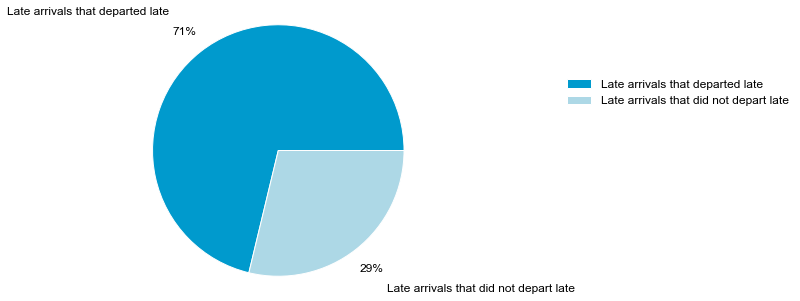

In [286]:
fig, ax = plt.subplots(figsize=(5,5))

plt.rcParams['text.color'] = '#000000'
plt.rcParams['axes.labelcolor']= '#000000'
plt.rcParams['xtick.color'] = '#000000'
plt.rcParams['ytick.color'] = '#000000'
plt.rcParams['font.size']=12

color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']

labels = ['Late arrivals that departed late','Late arrivals that did not depart late']
percentages = [ late_arrivals_departed_late['dep_delay'].count() / total_late_arrivals['arr_delay'].count(), 1 - late_arrivals_departed_late['dep_delay'].count() / total_late_arrivals['arr_delay'].count()]
explode=(0,0)
ax.pie(percentages, explode=explode, labels=labels,  
       colors=color_palette_list[0:2], autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
#ax.set_title('Percentage of late arrivals that departed late')
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))
plt.show()

#### The percentage of late arrivals that began late is rather high,71%.

#### 

#### Number of late arrivals where the arrival delay is less than the departure delay

In [287]:
arr_delay_less_than_dep_delay = total_late_arrivals[total_late_arrivals['arr_delay'] < total_late_arrivals['dep_delay']]

In [288]:
print('Number of total late arrivals: ', str(total_late_arrivals['arr_delay'].count()))
print('Number of late arrivals where the arr_delay is less than dep_delay: ', str(arr_delay_less_than_dep_delay['arr_delay'].count()))
print('Percentage of late arrivals where arr_delay is less than dep_delay: ', str(arr_delay_less_than_dep_delay['arr_delay'].count()/total_late_arrivals['arr_delay'].count()))

Number of total late arrivals:  5475608
Number of late arrivals where the arr_delay is less than dep_delay:  2319535
Percentage of late arrivals where arr_delay is less than dep_delay:  0.42361231848591063


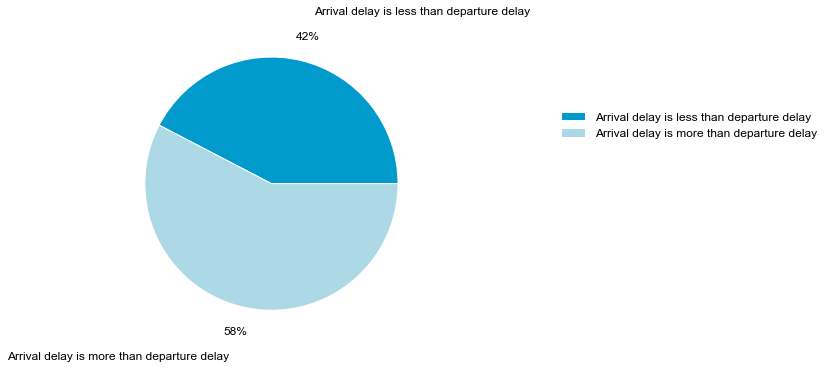

In [289]:
fig, ax = plt.subplots(figsize=(5,5))

plt.rcParams['text.color'] = '#000000'
plt.rcParams['axes.labelcolor']= '#000000'
plt.rcParams['xtick.color'] = '#000000'
plt.rcParams['ytick.color'] = '#000000'
plt.rcParams['font.size']=12

color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']

labels = ['Arrival delay is less than departure delay','Arrival delay is more than departure delay']
percentages = [arr_delay_less_than_dep_delay['arr_delay'].count()/total_late_arrivals['arr_delay'].count(), 1 - arr_delay_less_than_dep_delay['arr_delay'].count()/total_late_arrivals['arr_delay'].count()]
explode=(0,0)
ax.pie(percentages, explode=explode, labels=labels,  
       colors=color_palette_list[0:2], autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
#ax.set_title('Percentage of late arrivals that departed late')
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))
plt.show()

#### We can also see that a sizable percentage of late arrivals have delays that are less then departure delays, meaning that some pilots are able to reduce the time of delay during the flight. As shown in the a follwing task, we can see that some pilots do try to increase speed when they are late. 

#### 